<a href="https://colab.research.google.com/github/TheSpaceMan915/Artificial-Intelligence/blob/main/Lab15_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторная работа №15  Колычев Никита  ВПР34**

# **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
import json
import string
import random
from random import shuffle
from pathlib import Path
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.saving import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, \
BatchNormalization, Input, ReLU, Softmax

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Text Functions**

In [ ]:
# removing punctuation marks from a string
def remove_punctuation(text):
  table = str.maketrans('', '', string.punctuation)
  cleared_text = text.translate(table)
  return cleared_text

In [ ]:
def create_list_tokens(text):
  list_tokens = word_tokenize(text, language="russian")
  return list_tokens

In [ ]:
def convert_tokes_to_lowercase(list_tokens):
  list_lowercase_tokes = [token.lower() for token in list_tokens]
  return list_lowercase_tokes

In [ ]:
def remove_stopwords(list_tokens):
  list_stopwords = nltk.corpus.stopwords.words("russian")
  cleared_list_tokens = [token for token in list_tokens if token not in list_stopwords]
  return cleared_list_tokens

In [ ]:
def remove_nonalphabetic_words(list_tokens):
  cleared_list_tokens = [token for token in list_tokens if token.isalpha()]
  return cleared_list_tokens

In [ ]:
def create_list_lemmas(list_tokens):
  lemmatizer = WordNetLemmatizer()
  list_lemmas = [lemmatizer.lemmatize(token) for token in list_tokens]
  return list_lemmas

In [ ]:
def clear_text(text):
  cleared_text = remove_punctuation(text)
  list_tokens = create_list_tokens(cleared_text)
  cleared_list_tokens = remove_nonalphabetic_words(list_tokens)
  cleared_list_tokens = remove_stopwords(cleared_list_tokens)
  list_lowercase_tokens = convert_tokes_to_lowercase(cleared_list_tokens)
  list_lemmas = create_list_lemmas(list_lowercase_tokens)
  return list_lemmas

# **Model Functions**

In [ ]:
def create_model(input_layer_shape, NUMBER_CLASSES):
  inputs = Input(input_layer_shape)
  x = Dense(128, kernel_initializer="he_uniform")(inputs)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)

  x = Dense(64, kernel_initializer="he_uniform")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Dropout(0.2)(x)

  x = Dense(NUMBER_CLASSES, kernel_initializer="he_uniform")(x)
  outputs = Softmax()(x)

  model = Model(inputs, outputs)
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  return model

# **Plotting Functions**

In [ ]:
def plot_model_history(model_history):
    fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(14, 5))
    plt.rcParams.update({"font.size": 14, "font.family": "serif"})

    axes1.plot(model_history.history["accuracy"], label="accuracy")
    axes1.plot(model_history.history["val_accuracy"], label="val_accuracy")
    axes1.set(title="Accuracy of the model")
    axes1.set(xlabel="Epoch")
    axes1.set(ylabel="Accuracy")
    axes1.legend(loc=4)

    axes2.plot(model_history.history["loss"], label="loss")
    axes2.plot(model_history.history["val_loss"], label="val_loss")
    axes2.set(title="Losses of the model")
    axes2.set(xlabel="Epoch")
    axes2.set(ylabel="Loss")
    axes2.legend(loc=1)

    fig.tight_layout()
    plt.savefig("plot_model_history{}".format(random.randint(0, 10000)))

# **User Input Functions**

In [ ]:
def create_list_tags(json_file):
  list_tags = []
  for intent in json_file["intents"]:
      list_tags.append(intent["tag"])  
  return list_tags        

In [ ]:
def create_bag_words(text, list_vocabulary_words, show_details=False):
  cleared_list_tokens = clear_text(text)

  # creating a bag of words for the user's input
  list_length = len(list_vocabulary_words)
  bag_words = [0] * list_length
  for s in cleared_list_tokens:
      for i, w in enumerate(list_vocabulary_words):
          if w == s:
              bag_words[i] = 1
              if show_details:
                  print("Found in bag: %s"% w)
  
  # reshaping the 1d array to 2d array in order to pass it to the model
  arr_bag_words = np.array(bag_words)
  arr_bag_words = np.reshape(arr_bag_words, (-1, list_length))
  return arr_bag_words

In [ ]:
def classify(text, list_vocabulary_words, list_tags):
  ERROR_THRESHOLD = 0.25
  bag_words = create_bag_words(text, list_vocabulary_words)
  print("bag_words for the text:", bag_words)
  arr_predictions = model.predict(bag_words)[0]

  # filtering the predictions
  arr_predictions  = [[i, prediction] for i, prediction in enumerate(arr_predictions) if prediction > ERROR_THRESHOLD]

  # sorting the predictions according to their probability
  arr_predictions .sort(key=lambda x: x[1], reverse=True)

  # getting the list of labels and predictions
  list_labels = []
  for prediction in arr_predictions:
      list_labels.append((list_tags[prediction[0]], prediction[1]))
  return list_labels

In [ ]:
def query(text, list_vocabulary_words, list_tags, intents, userID="123", show_details=False):
  dict_context = {}
  list_results = classify(text, list_vocabulary_words, list_tags)

  if list_results:
      while list_results:
          for intent in intents["intents"]:    
              # finding the tag for the first result
              if intent["tag"] == list_results[0][0]:
                  
                  # setting the context for this intent
                  if "context_set" in intent:
                      dict_context[userID] = intent["context_set"]

                  # checking if the context is relevant to the user
                  if not "context_filter" in intent or \
                      (userID in dict_context and "context_filter" in intent and intent["context_filter"] == dict_context[userID]):
                      if show_details: 
                        print ("tag:", intent["tag"]) 
                      
                      # getting a random respons
                      return print(random.choice(intent["responses"]))
          list_results.pop(0)

# **Задание 1**
Разработать чат бота

In [ ]:
# loading the data from the json file
path = Path("/content/drive/MyDrive/Colab Notebooks/AI/Other files/my_intents.json")
with open(path) as f:
  my_intents = json.load(f)

In [ ]:
list_vocabulary_words = []
list_documents = []
list_tags = create_list_tags(my_intents)

# clearing the text
for intent in my_intents["intents"]:
  for pattern in intent["patterns"]:
    cleared_list_tokens = clear_text(pattern)
    list_vocabulary_words.extend(cleared_list_tokens)

    # saving a pattern as a document
    list_documents.append((cleared_list_tokens, intent["tag"]))

In [ ]:
print("number of words:", len(list_vocabulary_words))
print("words:")
print(list_vocabulary_words)
print()

print("number of  documents:", len(list_documents))
print("documents:")
print(list_documents)
print()

print("number of tags:", len(list_tags))
print("tags:")
print(list_tags)
print()

number of words: 42
words:
['привет', 'как', 'дела', 'ктонибудь', 'привет', 'добрый', 'день', 'пока', 'увидимся', 'позже', 'до', 'свидания', 'спасибо', 'спасибо', 'это', 'полезно', 'как', 'просмотреть', 'данные', 'своём', 'прогрессе', 'где', 'могу', 'узнать', 'количество', 'оставшихся', 'уроков', 'как', 'узнать', 'ежедневную', 'активность', 'сайте', 'где', 'могу', 'найти', 'уроки', 'где', 'находятся', 'уроки', 'как', 'просмотреть', 'уроки']

number of  documents: 17
documents:
[(['привет'], 'приветствие'), (['как', 'дела'], 'приветствие'), (['ктонибудь'], 'приветствие'), (['привет'], 'приветствие'), (['добрый', 'день'], 'приветствие'), (['пока'], 'до свидания'), (['увидимся', 'позже'], 'до свидания'), (['до', 'свидания'], 'до свидания'), (['спасибо'], 'спасибо'), (['спасибо'], 'спасибо'), (['это', 'полезно'], 'спасибо'), (['как', 'просмотреть', 'данные', 'своём', 'прогрессе'], 'личный кабинет'), (['где', 'могу', 'узнать', 'количество', 'оставшихся', 'уроков'], 'личный кабинет'), (['как

In [ ]:
# deleting duplicates
cleared_list_vocabulary_words = sorted(list(set(list_vocabulary_words)))
print("number of words:", len(cleared_list_vocabulary_words))
print(cleared_list_vocabulary_words)

number of words: 30
['активность', 'где', 'данные', 'дела', 'день', 'до', 'добрый', 'ежедневную', 'как', 'количество', 'ктонибудь', 'могу', 'найти', 'находятся', 'оставшихся', 'позже', 'пока', 'полезно', 'привет', 'прогрессе', 'просмотреть', 'сайте', 'свидания', 'своём', 'спасибо', 'увидимся', 'узнать', 'уроки', 'уроков', 'это']


In [ ]:
# creating data to train the model
list_training = []

# creating a list to store outputs
list_empty_outputs = [0] * len(list_tags)
for document in list_documents:
  bag_words = []

  # saving the patterns from the tuples ([patters], tag)
  list_patterns = document[0]
  
  # filling the bag of words
  for word in cleared_list_vocabulary_words:
    bag_words.append(1) if word in list_patterns else bag_words.append(0)

  # marking the tag of a document as 1
  list_output = list_empty_outputs.copy()
  list_output[list_tags.index(document[1])] = 1
  list_training.append([bag_words, list_output])
  print(list_training)

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]]
[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]]
[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]]
[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]], [[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]

In [ ]:
# shuffling the list
shuffle(list_training)
for list_words in list_training:
  print(list_words)

[[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 0]]
[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1]]
[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]
[[0, 1, 0,

In [ ]:
# preparing the data
arr_training = np.array(list_training, dtype=object)
dataset = list(arr_training[:, 0])
labels = list(arr_training[:, 1])
train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.2, random_state=0)

In [ ]:
NUMBER_CLASSES = len(list_tags)
input_layer_shape = (len(train_dataset[0]), )
print("input_layer_shape:", input_layer_shape)

input_layer_shape: (30,)


In [ ]:
model = create_model(input_layer_shape, NUMBER_CLASSES)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_9 (Dense)             (None, 128)               3968      
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                           

In [ ]:
model_history = model.fit(train_dataset, train_labels,
          validation_data=(test_dataset, test_labels),
          epochs=200, batch_size=1024,
          verbose=1)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 2.1302 - accuracy: 0.1538 - val_loss: 1.4286 - val_accuracy: 0.5000
Epoch 2/200
1/1 [==============================] - 0s 98ms/step - loss: 1.8983 - accuracy: 0.2308 - val_loss: 1.4152 - val_accuracy: 0.5000
Epoch 3/200
1/1 [==============================] - 0s 90ms/step - loss: 1.8833 - accuracy: 0.1538 - val_loss: 1.4043 - val_accuracy: 0.5000
Epoch 4/200
1/1 [==============================] - 0s 106ms/step - loss: 1.5359 - accuracy: 0.3077 - val_loss: 1.3935 - val_accuracy: 0.5000
Epoch 5/200
1/1 [==============================] - 0s 95ms/step - loss: 1.4073 - accuracy: 0.6154 - val_loss: 1.3855 - val_accuracy: 0.5000
Epoch 6/200
1/1 [==============================] - 0s 90ms/step - loss: 1.4214 - accuracy: 0.3846 - val_loss: 1.3767 - val_accuracy: 0.5000
Epoch 7/200
1/1 [==============================] - 0s 105ms/step - loss: 1.2236 - accuracy: 0.4615 - val_loss: 1.3672 - val_accuracy: 0.5000
Epoch 8/200
1/1 [===

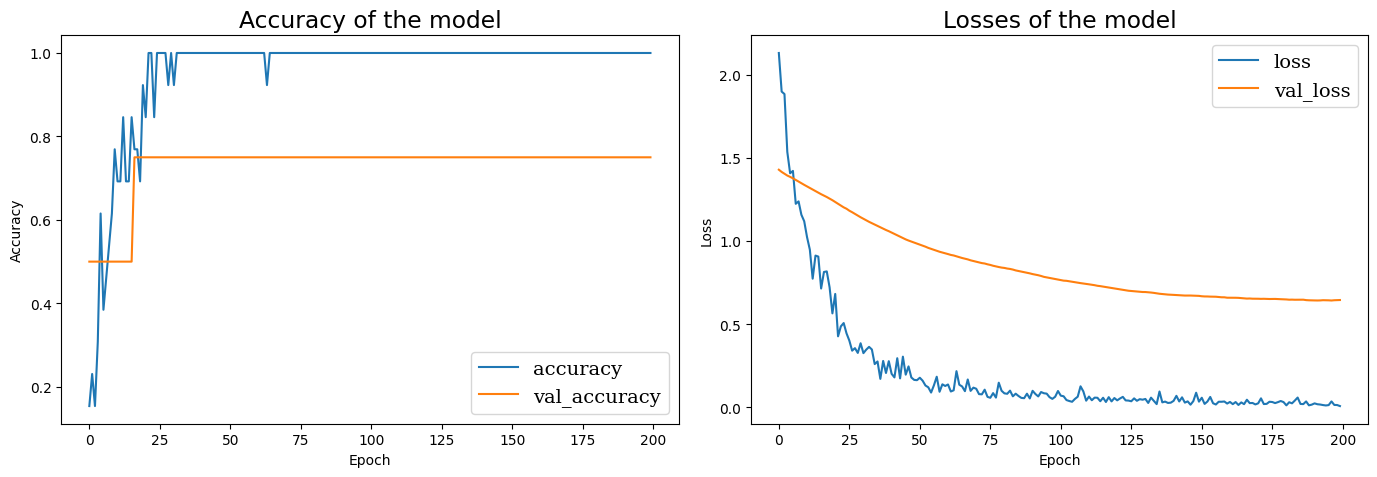

In [ ]:
plot_model_history(model_history)

In [ ]:
model.save("lab15_model.h5")

In [ ]:
# loading the saved model
path = Path("/content/drive/MyDrive/Colab Notebooks/AI/Other files/lab15_model.h5")
model = load_model(path)

In [ ]:
query("Привет", cleared_list_vocabulary_words, 
      list_tags, my_intents, show_details=True)

bag_words for the text: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 22ms/step
tag: приветствие
Здравствуйте, спасибо за визит


In [ ]:
query("Как дела", cleared_list_vocabulary_words, 
      list_tags, my_intents, show_details=True)

bag_words for the text: [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 23ms/step
tag: приветствие
Рад вас снова видеть


In [ ]:
query("Где я могу найти уроки?", cleared_list_vocabulary_words, 
      list_tags, my_intents, show_details=True)

bag_words for the text: [[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
1/1 [==============================] - 0s 43ms/step
tag: уроки
Вы можете просмотреть все имеющиеся на сайте уроки в разделе "Каталог уроков"


In [ ]:
query("Спасибо", cleared_list_vocabulary_words, 
      list_tags, my_intents, show_details=True)

bag_words for the text: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]
1/1 [==============================] - 0s 23ms/step
tag: спасибо
Рады помочь!
